<a href="https://colab.research.google.com/github/ShaelinN/GameOutcomePrediction/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
root = "/content/drive/MyDrive/COMP721_Project"

In [3]:
data = os.path.join(root, "Data")

#preprocessing

In [240]:
player_rs_career = pd.read_csv(os.path.join(data, "player_regular_season_career.csv"))
player_rs_career.head()

,ilkid,firstname,lastname,leag,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
0,ABDELAL01,Alaa,Abdelnaby,N,256,3200,1465,283,563,846,85,71,69,247,484,1236,620,321,225,3,0
1,ABDULKA01,Kareem,Abdul-jabbar,N,1560,57446,38387,2975,9394,17440,5660,1160,3189,2527,4657,28307,15837,9304,6712,18,1
2,ABDULMA01,Mahmo,Abdul-rauf,N,586,15633,8553,219,868,1087,2079,487,46,963,1107,7943,3514,1161,1051,1339,474
3,ABDULTA01,Tariq,Abdul-wahad,N,236,4808,1830,275,501,776,266,184,82,309,485,1726,720,529,372,76,18
4,ABDURSH01,Shareef,Abdur-rahim,N,672,24862,13338,1498,3976,5474,1847,718,556,1911,1845,10215,4789,4427,3614,477,146


In [241]:
player_keys = player_rs_career.loc[:,:"leag"]
player_vecs = player_rs_career.loc[:,"gp":]
player_vecs.head()

,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,fga,fgm,fta,ftm,tpa,tpm
0,256,3200,1465,283,563,846,85,71,69,247,484,1236,620,321,225,3,0
1,1560,57446,38387,2975,9394,17440,5660,1160,3189,2527,4657,28307,15837,9304,6712,18,1
2,586,15633,8553,219,868,1087,2079,487,46,963,1107,7943,3514,1161,1051,1339,474
3,236,4808,1830,275,501,776,266,184,82,309,485,1726,720,529,372,76,18
4,672,24862,13338,1498,3976,5474,1847,718,556,1911,1845,10215,4789,4427,3614,477,146


#Models

##prep

In [242]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [243]:
OCSVM = svm.OneClassSVM(nu=0.08)
IF = IsolationForest(contamination=0.02)
EE = EllipticEnvelope(contamination=0.08)

model = IF

##execution

In [244]:
pca = PCA(n_components=2)
out_player_vecs = pca.fit_transform(player_vecs)

outlier_results = model.fit_predict(out_player_vecs)
outlier_results

array([ 1, -1,  1, ...,  1,  1,  1])

In [245]:
out_player_keys = player_keys.copy()
out_player_keys["outlier"] = outlier_results
out_player_keys.head()

,ilkid,firstname,lastname,leag,outlier
0,ABDELAL01,Alaa,Abdelnaby,N,1
1,ABDULKA01,Kareem,Abdul-jabbar,N,-1
2,ABDULMA01,Mahmo,Abdul-rauf,N,1
3,ABDULTA01,Tariq,Abdul-wahad,N,1
4,ABDURSH01,Shareef,Abdur-rahim,N,1


In [246]:
pca = PCA(n_components=2)
out_player_vecs = pca.fit_transform(player_vecs)

In [247]:
C_0 = out_player_vecs[np.argwhere(outlier_results==-1)] # outlier
C_1 = out_player_vecs[np.argwhere(outlier_results==1)]  #inlier

C_all = out_player_vecs

In [248]:
C_0 = C_0.transpose()
C_1 = C_1.transpose()

C_all = C_all.transpose()

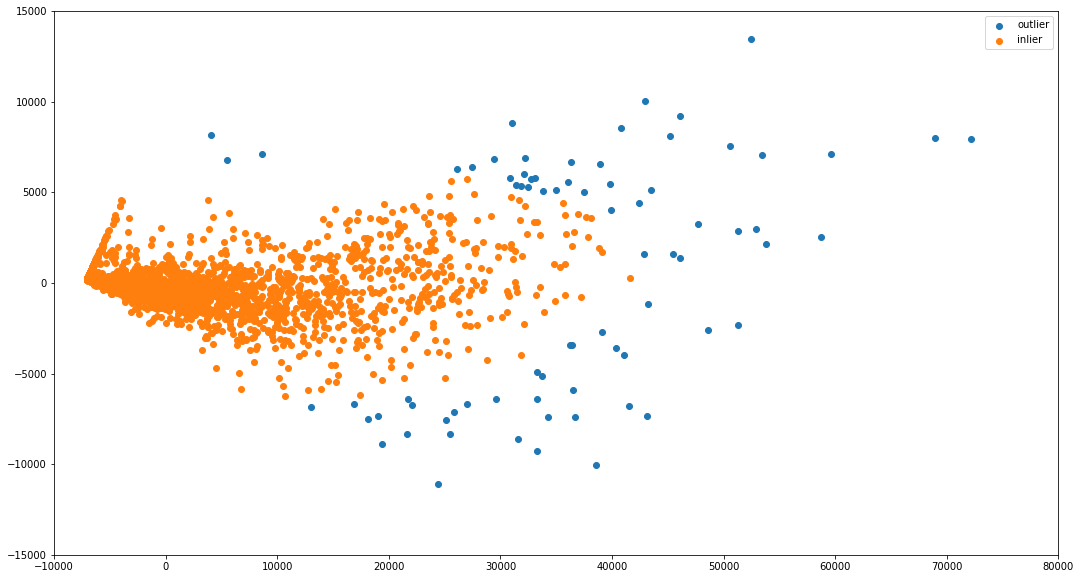

In [249]:
plt.figure(figsize=(18,10))

plt.scatter(C_0[0], C_0[1], label='outlier') #outlier
plt.scatter(C_1[0], C_1[1], label='inlier')

plt.xlim(-10000,80000)
plt.ylim(-15000,15000)
plt.legend()

#informal evaluation

this is not a true evaluation, since the metrics used do not apply in the case of unsupervised learning. Rather, it checks for correlation between those players rated outlier and those who at some time were in the all-stars.

In [250]:
all_stars= pd.read_csv(os.path.join(data, "player_allstar.csv"))
all_stars.head()
all_stars["ilkid"] = [i.upper().strip() for i in all_stars["ilkid"]]

In [272]:
groupbyid = all_stars[["ilkid"]].groupby("ilkid", as_index=False)
count = groupbyid.size()
count.columns = ["ilkid","times_allstar"]


In [284]:
players = pd.merge(out_player_keys, count,how="left", on="ilkid")
players["times_allstar"] = players["times_allstar"].fillna(0)
players

,ilkid,firstname,lastname,leag,outlier,times_allstar
0,ABDELAL01,Alaa,Abdelnaby,N,1,0.0
1,ABDULKA01,Kareem,Abdul-jabbar,N,-1,19.0
2,ABDULMA01,Mahmo,Abdul-rauf,N,1,0.0
3,ABDULTA01,Tariq,Abdul-wahad,N,1,0.0
4,ABDURSH01,Shareef,Abdur-rahim,N,1,1.0
...,...,...,...,...,...,...
3754,ZEVENPH01,Phil,Zevenbergen,N,1,0.0
3755,ZIDEKGE01,George,Zidek,N,1,0.0
3756,ZOETJI01,Jim,Zoet,N,1,0.0
3757,ZOPFBI01,Bill,Zopf,N,1,0.0



#what proportion of players were in allstars?


In [285]:
stars = players.where(players["times_allstar"] != 0).dropna()

stars.shape[0]/players.shape[0]


0.12476722532588454

#what proportion of inliers were in allstars?

In [287]:
inliers = players.where(players["outlier"] == 1).dropna()

stars = inliers.where(inliers["times_allstar"] != 0).dropna()


stars.shape[0]/inliers.shape[0]


0.10860711376595167

#what proportion of outliers were in allstars?

In [286]:
outliers = players.where(players["outlier"] == -1).dropna()

stars = outliers.where(outliers["times_allstar"] != 0).dropna()


stars.shape[0]/outliers.shape[0]


0.9078947368421053